### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [2055]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2421]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    
    def find_F(self, count, N):
        return  1 - ((count.astype('float') / N) ** 2).sum(axis=1) 
    
    
    def find_F_entr(self, count, N):
        probab = (count.astype('float') / N)
        probab_log = np.log(probab)
        probab_log[probab_log == -np.inf] = 0
        return -((probab * probab_log).sum(axis=1)) 
    
    
    def find_F_missclass(self, count, N):
        return 1 - (count.astype('float') / N).max(axis=1)
    
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        Q_criteria =  (self.find_F(count_middle, N_middle) 
                                       - N_left / N_middle * self.find_F(count_left, N_left) 
                                       - N_right / N_middle * self.find_F(count_right, N_right))
        """
        # Ваш код здесь
        index = np.argsort(x)
        x_sort = x[index]
        y_sort = y[index]
        pos_splits = np.asarray(y_sort[:-1] != y_sort[1:]).nonzero()[0]
        if pos_splits.size == 0:
            return 0, np.inf
        classes_count = np.zeros((y_sort.shape[0] - 1, self.num_class))
        classes_count[np.arange(y_sort.shape[0] - 1), y_sort[:-1]] = 1
        classes_count_left = np.cumsum(classes_count, axis=0)
        classes_count_right = np.bincount(y_sort, minlength=self.num_class) - classes_count_left
        classes_size_left = np.sum(classes_count_left, axis=1)
        classes_size_right = y_sort.shape[0] - classes_size_left
        #classes_size number of all classes in node, classes_count number of each class
        if self.criterion == 'gini':
            Q = (self.find_F(classes_count_left + classes_count_right, y.shape[0]) 
                - classes_size_left / y.shape[0] * self.find_F(classes_count_left, classes_size_left.reshape(-1, 1))
                - classes_size_right / y.shape[0] * self.find_F(classes_count_right, classes_size_right.reshape(-1, 1)))
        if self.criterion == 'entropy':
            Q = (self.find_F_entr(classes_count_left + classes_count_right, y.shape[0]) 
                - classes_size_left / y.shape[0] * self.find_F_entr(classes_count_left, classes_size_left.reshape(-1, 1))
                - classes_size_right / y.shape[0] * self.find_F_entr(classes_count_right, classes_size_right.reshape(-1, 1)))
        if self.criterion == 'missclass':
            Q = (self.find_F_missclass(classes_count_left + classes_count_right, y.shape[0]) 
            - classes_size_left / y.shape[0] * self.find_F_missclass(classes_count_left, classes_size_left.reshape(-1, 1))
            - classes_size_right / y.shape[0] * self.find_F_missclass(classes_count_right, classes_size_right.reshape(-1, 1)))
        Q = Q[~np.isnan(Q)]
        if Q.size == 0:
            return 0, np.inf
        ind = np.argmax(Q)
        return Q[ind], x_sort[ind]

    def __prefind_threshold(self, x, y):
        QandThresholds = np.asarray([self.__find_threshold(x[:, i], y) for i in range(x.shape[1])])
        ind = np.argmax(QandThresholds[:, 0])
        self.feature_importances_[ind] += QandThresholds[ind, 0]
        return ind, QandThresholds[ind, 1]

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        values, count = np.unique(y, return_counts=1)
        pos_of_predicted_class = np.argmax(count)
        predicted_class = values[pos_of_predicted_class]
        probability = count[pos_of_predicted_class] / y.shape[0]
        if  depth == self.max_depth or x.shape[0] < self.min_samples_split:
            self.tree[node_id] = (1, predicted_class, probability) # 0 for LEAF_TYPE
        else:
            opt_feature, threshold = self.__prefind_threshold(x, y)
            self.tree[node_id] = (0, opt_feature, threshold)
            x_l, x_r, y_l, y_r = self.__div_samples(x, y, opt_feature, threshold)
            if x_l.size == 0 or x_r.size == 0:
                self.tree[node_id] = (1, predicted_class, probability)
            else:
                self.__fit_node(x_l , y_l, node_id * 2 + 1, depth + 1)
                self.__fit_node(x_r, y_r, node_id * 2 + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros(x.shape[1])
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == 0:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_ 

In [2261]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'gini')
clf = DecisionTreeClassifier(min_samples_split=2)

In [2262]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [2263]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [2265]:
my_clf.predict(X_test)

array([1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0])

In [2266]:
clf.predict(X_test)

array([1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0])

In [2267]:
print(accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
print(accuracy_score(y_pred=my_clf.predict(X_train), y_true=y_train))

1.0
1.0


In [2268]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


In [2269]:
my_clf.get_feature_importance()

array([0.18      , 0.        , 0.04442149, 0.        , 0.        ,
       0.        , 0.41356352, 0.        , 0.        , 0.2497893 ,
       0.        , 0.06527323, 0.2637404 ])

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [2232]:
%time clf.fit(X_train, y_train)

CPU times: user 6.06 ms, sys: 129 µs, total: 6.19 ms
Wall time: 6.51 ms


DecisionTreeClassifier()

In [2233]:
%time my_clf.fit(X_train, y_train)

CPU times: user 26.9 ms, sys: 55 µs, total: 26.9 ms
Wall time: 27 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [2422]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [2423]:
df = pd.read_csv('./data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [2424]:
for i in df.columns:
    if (type(df[i][0]) == np.float64 or type(df[i][0]) == np.int64 or type(df[i][0]) == float):
        continue
    else:
        df.drop(i, axis = 1, inplace = True)
for i in df.columns:
    if df[i].isnull().sum() > 1000:
        df.drop(i,axis=1, inplace=True)

In [2425]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o'], 
             axis=1)

In [2426]:
df = df.fillna(-500000)
y = df.loc[:, 'match'].values
df.drop(['match','dec','dec_o','like_o', 'like'], axis=1, inplace = True)
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [2427]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [2428]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [2429]:
my_clf.fit(X_train, y_train)

In [2430]:
from sklearn.metrics import accuracy_score, f1_score

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [2431]:
from sklearn.model_selection import cross_val_score
from matplotlib.pyplot import plot

In [2432]:
for i in ['entropy', 'gini', 'missclass']:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion=i)
    print(i, cross_val_score(my_clf, X_train, y_train, cv=5, scoring='accuracy').mean())

/home/vlad/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


entropy 0.8473729156301191
gini 0.8473742249533736
missclass 0.8369713607360143


In [2388]:
from tqdm import tqdm

In [2433]:
maxim = 0
for_graph0 = []
for_graph1 = []
for i in tqdm(range(2, 50)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=i, criterion='gini')
    score = cross_val_score(my_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    for_graph0.append(i)
    for_graph1.append(score)
    if score > maxim:
        print(score)
        maxim = score
        opt = i
print(opt, maxim)

  2%|▏         | 1/48 [00:01<01:30,  1.92s/it]

0.8473742249533736


 35%|███▌      | 17/48 [00:33<01:01,  1.97s/it]

0.8475448734175373


100%|██████████| 48/48 [01:33<00:00,  1.95s/it]

18 0.8475448734175373


##### График в зависимости от количество самплов для сплита

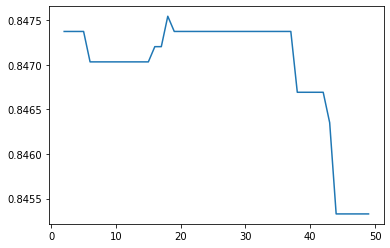

In [2434]:
plot(for_graph0, for_graph1)

In [2435]:
maxim = 0
opt = 0
for_graph0 = []
for_graph1 = []
for i in tqdm(range(2, 50)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=18, criterion='gini', max_depth=i)
    score = cross_val_score(my_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    for_graph0.append(i)
    for_graph1.append(score)
    if score > maxim:
        print(score)
        maxim = score
        opt = i
print(opt, maxim)

  2%|▏         | 1/48 [00:00<00:28,  1.66it/s]

0.8403814204120585


  4%|▍         | 2/48 [00:01<00:32,  1.41it/s]

0.8466922130181647


  8%|▊         | 4/48 [00:04<00:53,  1.23s/it]

0.8475448734175373


100%|██████████| 48/48 [02:56<00:00,  3.69s/it]

5 0.8475448734175373


##### График зависимости от глубины

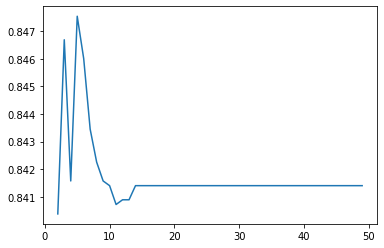

In [2436]:
plot(for_graph0, for_graph1)

In [2437]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='gini', max_depth=5)

In [2438]:
my_clf.fit(X_train, y_train)

### Максимальная точность

In [2439]:
from sklearn.metrics import accuracy_score

In [2440]:
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8353221957040573


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

### Вывел номера фичей

In [2441]:
num_best_features = np.argsort(my_clf.get_feature_importance())[-10:]
print(num_best_features, my_clf.get_feature_importance()[num_best_features])

[54 65 62 16  9 14 67 10 55  2] [0.03792255 0.04602437 0.06197913 0.06570372 0.07092336 0.09999828
 0.10769463 0.14535755 0.17825521 0.36517329]


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь
Вобще реализация быстрого алгоритма показалась вобще неочевидной, долго было не понятно как это сделать.


* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

